In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020

Cloning into 'Informer2020'...


In [14]:
%cd Informer2020/
!cp ../../datasets/btc-usdt-1.csv data/

d:\efficient-transformers-4seqdata\informer_experiments\Informer2020


In [3]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [24]:
root_path = '.'
data_path = 'data/btc-usdt-1.csv'

df = pd.read_csv(os.path.join(root_path, data_path))
df['target'] = (df['bid_price'] + df['ask_price'])/2
df = df.drop(['exchange_time', 'instrument', 'bid_price', 'bid_size', 'ask_price', 'ask_size'], axis = 1)
df.columns = df.columns.str.replace('our_time', 'date')
df.to_csv('data_clean.csv',index = False, sep=',')

In [25]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'target' # target feature in S or MS task
args.freq = 's' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 1 # encoder input size
args.dec_in = 1 # decoder input size
args.c_out = 1 # output size
args.factor = 1 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

args.batch_size = 1
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 1
args.patience = 1
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [26]:
args.root_path = '.'
args.data_path = 'data_clean.csv'

In [27]:
'''
set 'target'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

timeenc = 0 if args.embed!='timeF' else 1
flag = 'train'; shuffle_flag = True; drop_last = True; batch_size = 1

data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, 
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [28]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

# Training section. Skip it if you want to do the inference

In [23]:
Exp = Exp_Informer
args.data = 'custom'
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftS_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc1_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 60383
val 8641
test 17280
	iters: 100, epoch: 1 | loss: 0.0094061
	speed: 0.0260s/iter; left time: 1568.6771s
	iters: 200, epoch: 1 | loss: 0.0381509
	speed: 0.0252s/iter; left time: 1519.5666s
	iters: 300, epoch: 1 | loss: 0.0125165
	speed: 0.0257s/iter; left time: 1541.4178s
	iters: 400, epoch: 1 | loss: 0.0624162
	speed: 0.0254s/iter; left time: 1524.5366s
	iters: 500, epoch: 1 | loss: 0.0404067
	speed: 0.0255s/iter; left time: 1525.5056s
	iters: 600, epoch: 1 | loss: 0.0362380
	speed: 0.0246s/iter; left time: 1470.5633s
	iters: 700, epoch: 1 | loss: 0.0157494
	speed: 0.0256s/iter; left time: 1525.7891s
	iters: 800, epoch: 1 | loss: 0.0085988
	speed: 0.0250s/iter; left time: 1487.7355s
	iters: 900, epoch: 1 | loss: 0.2186281
	speed: 0.0255s/iter; left time: 1516.3057s
	iters: 1000, epoch: 1 | loss: 0.0640308
	speed:

In [ ]:
torch.save(exp.state_dict(), './informer_checkpoint.pt')

# Inference section

### Memory footprint

In [31]:
import numpy as np
import time

In [ ]:
import gc
gc.collect(), torch.cuda.empty_cache()

In [ ]:
hyperparams = [
    15,
    30,
    60,
    120,
    240
]

In [ ]:
for enc_seq_len in hyperparams:
    checkpoint =  f'checkpoints_baseline/checkpoint_{enc_seq_len}.ckpt'
    args.seq_len = enc_seq_len
    args.label_len = int(args.seq_len / 2)
    exp = Exp_Informer(args)
    before_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    with torch.no_grad():
        exp.model.load_state_dict(torch.load(f'{checkpoint}')['state_dict'])
        pred_data, pred_loader = exp._get_data(flag='test')
        batch_x,batch_y,batch_x_mark,batch_y_mark = next(iter(pred_loader))
        pred, true = exp._process_one_batch(pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
    after_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    print(f'- - - - Seq length {args.seq_len}, Memory used = {before_inference - after_inference}')
    gc.collect(), torch.cuda.empty_cache()


### Inference speed

In [ ]:
def benchmark(model, src, tgt, src_mask, tgt_mask, dtype='fp32', nwarmup=50, nruns=1000, device='cuda', period=100):
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model.model(src, tgt, src_mask, tgt_mask)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model.model(src, tgt, src_mask, tgt_mask)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%period==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*nruns))

    print("Output features size:", features.size())

    print('Average batch time: %.2f ms'%(np.mean(timings)*nruns))

    return np.mean(timings)*nruns

In [ ]:
for enc_seq_len in hyperparams:
    checkpoint =  f'checkpoints_baseline/checkpoint_{enc_seq_len}.ckpt'
    args.seq_len = enc_seq_len
    args.label_len = int(args.seq_len / 2)
    print(f'current{args.seq_len}')
    exp = Exp_Informer(args)
    before_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    with torch.no_grad():
        exp.model.load_state_dict(torch.load(f'..//checkpoint_CL={args.seq_len}.pth'))

        pred_data, pred_loader = exp._get_data(flag='test')
        batch_x,batch_y,batch_x_mark,batch_y_mark = next(iter(pred_loader))
        benchmark(exp, pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
    after_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    gc.collect(), torch.cuda.empty_cache()


### Predictions quality

In [25]:
# test
print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

# torch.cuda.empty_cache()

>>>>>>>testing : informer_custom_ftS_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc1_ebtimeF_dtTrue_mxTrue_exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 17280
test shape: (17280, 1, 1, 1) (17280, 1, 1, 1)
test shape: (17280, 1, 1) (17280, 1, 1)
mse:7.218769073486328, mae:1.9692894220352173


In [28]:
import numpy as np
y_pred = np.load('/content/Informer2020/results/informer_custom_ftS_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc1_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
y_true = np.load('/content/Informer2020/results/informer_custom_ftS_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc1_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')

In [30]:
y_pred_1d = np.squeeze(y_pred)
y_true_1d = np.squeeze(y_true)

In [36]:
len(y_pred_1d)

17280

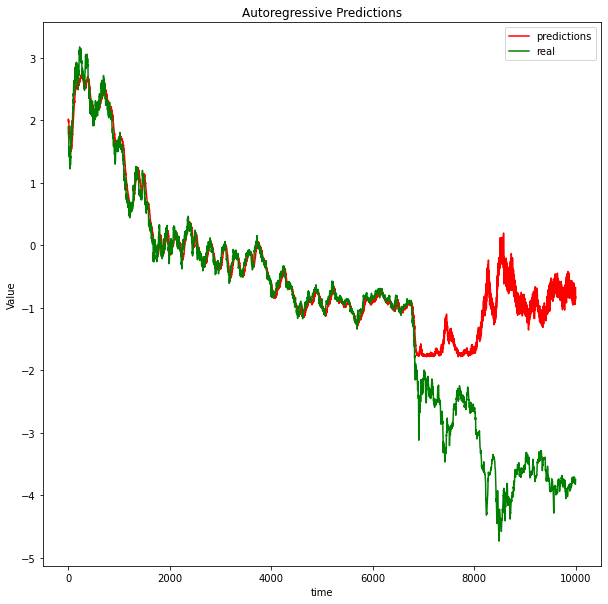

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

plt.plot(range(10000), y_pred_1d[:10000], color='r', label='predictions')
plt.plot(range(10000), y_true_1d[:10000], color='g', label='real')


plt.xlabel("time")
plt.ylabel("Value")
plt.title("Autoregressive Predictions")


plt.legend()


plt.show()